# chapter 4. Classification

## Ramdom Forest

### 랜덤 포레스트의 개요 및 실습

배깅의 대표적인 알고리즘은 **랜덤 포레스트**이다. <br>
앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있으며 다양한 영역에서 높은 예측 성능을 보인다. <br>
랜덤 포레스트의 기반 알고리즘은 결 트리로서 쉽고 직관적인 장점을 가지고 있다. <br>

**랜덤 포레스트**는 **여러 개의 결정 트리 분류리가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정**을 하게 된다. 

<img src = 'image/Random Forest.jpg' alt = 'Random Forest' width='600' height='600'>

랜덤 포레스트의 개별적인 분류기의 기반 알고리즘은 결정 트리이지만 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트이다. <br>
**여러 개의 데이터 세트를 중첩되게 분리하는 것**을 **부스트트래핑 분할 방식**이라고 한다. <br>
데이터가 중첩된 개별 데이터 세트에 결정 트리 분류기를 각각 적용하는 것이 랜덤 포레스트이다. <br>
사이킷런은 **RandomForestClassifier 클래스**를 통해 **랜덤 포레스트 기반의 분류를 지원**한다. 

In [26]:
# 이전 get_human_dataset() Data

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# feature.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있다. -> DataFrame으로 Load
feature_name_df = pd.read_csv('/Users/1001l1000/Documents/AI/Jen/data/human_activity/features.txt', sep = '\s+',
                             header = None, names = ['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출 : ', feature_name[:10])

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(),
                                 columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 
                                                              'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                               if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
    return new_feature_name_df

def get_human_dataset( ): 
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/Users/1001l1000/Documents/AI/Jen/data/human_activity/features.txt',sep = '\s+',
                        header = None, names = ['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/Users/1001l1000/Documents/AI/Jen/data/human_activity/train/X_train.txt', sep = '\s+', names = feature_name )
    X_test = pd.read_csv('/Users/1001l1000/Documents/AI/Jen/data/human_activity/test/X_test.txt', sep = '\s+', names = feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/Users/1001l1000/Documents/AI/Jen/data/human_activity/train/y_train.txt', sep = '\s+',header = None, names = ['action'])
    y_test = pd.read_csv('/Users/1001l1000/Documents/AI/Jen/data/human_activity/test/y_test.txt', sep = '\s+',header = None, names = ['action'])
    
    # 로드된 학습 / 테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

전체 피처명에서 10개만 추출 :  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습 / 테스트용 DataFrame 반환
X_train, X_test, Y_train, Y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0, max_depth = 8)
rf_clf.fit(X_train, Y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(Y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9196


### 랜덤 포레스트 하이퍼 파라미터 및 튜닝

트리 기반 앙상블의 단점은 하이퍼 파라미터가 너무 많고, 이로 인한 시간이 많이 소모된다는 점이다. <br>
트리 기반 자체의 하이퍼 파라미터가 원래 많은데 배깅, 부스팅, 학습, 정규화 등을 위한 하이퍼 파라미터까지 추가되므로 일반적으로 다른 ML 알고리즘에 비해 많을 수 밖에 없다. <br>
랜덤 포레스트가 적은 편에 속하는데, 결정 트리에서 사용되는 하이퍼 마라미터와 같은 파라미터가 대부분이기 때문이다. <br>

- n_estimators : 랜덤 포레스트에서 결정 트리의 개수를 지정한다. 디폴트는 10개이다. 많이 설정할 수록 좋은 성능을 기대할 수 있지만 계속 증가시킨다고 성능이 향상되는 것은 아니다. 또한 늘릴수록 학습 수행 시간이 오래걸리는 것도 감안해야 한다. 
- max_feature : 결정 트리에서 사용된 max_feature 파라미터와 같다. 하지만 RandomForestClassifier의 기본 max_feature는 'None'이 아니라 'auto'. 즉 'sqrt'와 같다. 따라서 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 전체 피처가 아니라 sqrt만큼 참조한다. 
- max_depth나 min_samples_leat, min_sample_split와 같이 결정 트리에서 과적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에도 공통적으로 적용된다. 

랜덤 포레스트는 CPU 병렬 처리도 효과적으로 수행되어 빠른 학습이 가능하기 때문에 뒤에 소개할 그래디언트 부스팅보다 예측 성능이 약간 떨어지기라도 랜덤 포레스트로 일반 기반 모델을 먼저 구축하는 경우가 많다. 

In [31]:
# Error ! 
# n_estimators X
# Fix Code, https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected

from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12], 
    'min_samples_split' : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, Y_train.values.ravel())
# Fix Code, grid_cv.fit(X_train, Y_train) -> grid_cv.fit(X_train, Y_train.values.ravel())

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 : 
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 : 0.9165


In [32]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 6, max_depth = 16,
                                min_samples_split = 2, random_state = 0)
rf_clf1.fit(X_train, Y_train)
pred = rf_clf1.predict(X_test)
print('에측 정확도 : {0:.4f}'.format(accuracy_score(Y_test, pred)))

에측 정확도 : 0.9260


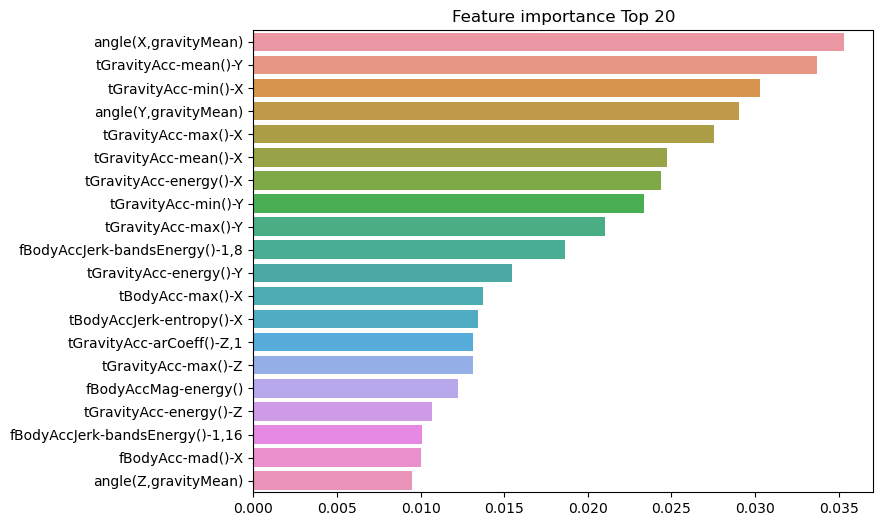

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importance Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()